In [1]:
cd ../

/home/ubuntu/github/predictive-maintenance/ml


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import random

from sklearn.preprocessing import normalize

from tqdm import tqdm

%matplotlib inline

tqdm.monitor_interval = 0

In [3]:
data_dir = 'data/dataset/'
model_save_path = 'data/wtte/model-1h-cycle/saved_model.h5'

In [4]:
telemetry = pd.read_csv(f'{data_dir}PdM_telemetry.csv')
failures = pd.read_csv(f'{data_dir}PdM_failures.csv')

**telemetry.csv** The first data source is the telemetry time-series data which consists of voltage, rotation, pressure and vibration measurements collected from 100 machines in real time averaged over every hour collected.

**failures.csv** These are the records of component replacements due to failures. Each record has a date and time, machine ID and failed component type.

## Simple Vis.

In [5]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [6]:
telemetry.machineID.nunique()

100

In [7]:
telemetry.dtypes

datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object

In [8]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [9]:
print(telemetry.machineID.nunique())
print(failures.machineID.nunique())

100
98


## Prepare Data

In [10]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [11]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [12]:
telemetry.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
dtype: object

In [13]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [14]:
print(telemetry.datetime.min())
print(telemetry.datetime.max())

2015-01-01 06:00:00
2016-01-01 06:00:00


In [15]:
# failures

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print('Total number of failures: {}'.format(len(failures)))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


Text(0, 0.5, 'Count')

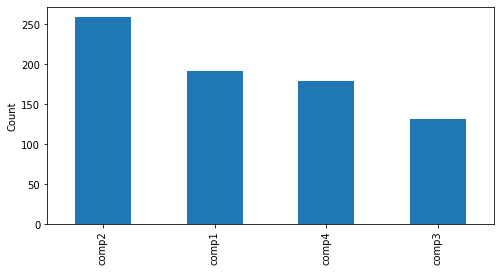

In [16]:
plt.figure(figsize=(8, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')

## Normliaze

In [17]:
telemetry["volt"] = (telemetry["volt"] - telemetry["volt"].mean()) / telemetry["volt"].std()
telemetry["rotate"] = (telemetry["rotate"] - telemetry["rotate"].mean()) / telemetry["rotate"].std()
telemetry["pressure"] = (telemetry["pressure"] - telemetry["pressure"].mean()) / telemetry["pressure"].std()
telemetry["vibration"] = (telemetry["vibration"] - telemetry["vibration"].mean()) / telemetry["vibration"].std()

In [18]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,0.350769,-0.533491,1.105948,0.875673
1,2015-01-01 07:00:00,1,-0.509282,-0.832626,-0.488578,0.564015
2,2015-01-01 08:00:00,1,0.013680,1.532917,-2.318898,-1.155632
3,2015-01-01 09:00:00,1,-0.536130,-1.907127,0.759357,0.137260
4,2015-01-01 10:00:00,1,-0.849031,-0.213165,0.998127,-2.680359


In [19]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,8.761000e+05,8.761000e+05,8.761000e+05,8.761000e+05
mean,50.500000,1.789195e-15,-3.522008e-15,-3.830069e-15,3.917701e-15
std,28.866087,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,1.000000,-4.735547e+00,-5.850585e+00,-4.491176e+00,-4.749765e+00
25%,25.750000,-6.752680e-01,-6.511653e-01,-6.661870e-01,-6.717814e-01
50%,50.500000,-1.098699e-02,1.809304e-02,-3.920010e-02,-2.751396e-02
75%,75.250000,6.594030e-01,6.753153e-01,6.060963e-01,6.330919e-01
max,100.000000,5.438543e+00,4.716110e+00,7.701674e+00,6.779073e+00


## Change the Life-cycle

In [20]:
# calculate the mean, std, max, and min values for 24h periods
def timesteps_handler(df, period='24H', fields = ['volt', 'rotate', 'pressure', 'vibration']):
    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').mean().unstack())
    df_mean_xh = pd.concat(temp, axis=1)
    df_mean_xh.columns = [i + '_mean_{}'.format(period.lower()) for i in fields]
    df_mean_xh.reset_index(inplace=True)

    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').std().unstack())
    df_sd_xh = pd.concat(temp, axis=1)
    df_sd_xh.columns = [i + '_sd_{}'.format(period.lower()) for i in fields]
    df_sd_xh.reset_index(inplace=True)
    
    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').max().unstack())
    df_max_xh = pd.concat(temp, axis=1)
    df_max_xh.columns = [i + '_max_{}'.format(period.lower()) for i in fields]
    df_max_xh.reset_index(inplace=True)
    
    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').min().unstack())
    df_min_xh = pd.concat(temp, axis=1)
    df_min_xh.columns = [i + '_min_{}'.format(period.lower()) for i in fields]
    df_min_xh.reset_index(inplace=True)
    
    df = pd.concat([
        df_mean_xh,
        df_sd_xh.iloc[:, 2:6],
        df_max_xh.iloc[:, 2:6],
        df_min_xh.iloc[:, 2:6]], axis=1).dropna()
    return df

In [21]:
# 24h periods
#telemetry = timesteps_handler(telemetry)
telemetry.head(10)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,0.350769,-0.533491,1.105948,0.875673
1,2015-01-01 07:00:00,1,-0.509282,-0.832626,-0.488578,0.564015
2,2015-01-01 08:00:00,1,0.013680,1.532917,-2.318898,-1.155632
3,2015-01-01 09:00:00,1,-0.536130,-1.907127,0.759357,0.137260
4,2015-01-01 10:00:00,1,-0.849031,-0.213165,0.998127,-2.680359
5,2015-01-01 11:00:00,1,0.111361,-0.309105,-0.446354,-0.880758
6,2015-01-01 12:00:00,1,-0.916990,0.996063,0.986273,0.441109
7,2015-01-01 13:00:00,1,0.112517,-0.702063,0.012890,-0.912974
8,2015-01-01 14:00:00,1,0.293169,-0.910439,0.883879,0.949150
9,2015-01-01 15:00:00,1,-0.100542,0.270448,0.361089,-0.089989


## Train, Validation, Test Split

In [22]:
import lightgbm as lgb

# make test and training splits
threshold_dates = [
        pd.to_datetime("2015-08-01 01:00:00"),
        pd.to_datetime("2015-11-01 01:00:00")
]

telemetry_train = telemetry[telemetry['datetime'] < threshold_dates[0]]
telemetry_valid = telemetry[
    (telemetry['datetime'] >= threshold_dates[0]) &
    (telemetry['datetime'] < threshold_dates[1])
]
telemetry_test = telemetry[(telemetry['datetime'] >= threshold_dates[1])]

failures_train = failures[failures['datetime'] < threshold_dates[0]]
failures_valid = failures[
    (failures['datetime'] >= threshold_dates[0]) &
    (failures['datetime'] < threshold_dates[1])
]
failures_test = failures[(failures['datetime'] >= threshold_dates[1])]

print(len(telemetry_train))
print(len(telemetry_valid))
print(len(telemetry_test))
print(len(failures_train))
print(len(failures_valid))
print(len(failures_test))

508300
220800
147000
458
182
121


In [23]:
telemetry_train.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,0.350769,-0.533491,1.105948,0.875673
1,2015-01-01 07:00:00,1,-0.509282,-0.832626,-0.488578,0.564015
2,2015-01-01 08:00:00,1,0.013680,1.532917,-2.318898,-1.155632
3,2015-01-01 09:00:00,1,-0.536130,-1.907127,0.759357,0.137260
4,2015-01-01 10:00:00,1,-0.849031,-0.213165,0.998127,-2.680359


In [24]:
failures_train.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
7,2015-03-19 06:00:00,2,comp1


## Prepare the Dataset

In [25]:
def data_handler(df_telemetry, df_failure):
    sample_id = 0
    cols = ['instance', 'timesteps', 'volt', 'rotate', 'pressure', 'vibration']
    """cols = [
        "instance",
        "timesteps",
        "volt_mean_24h",
        "rotate_mean_24h",
        "pressure_mean_24h",
        "vibration_mean_24h",
        "volt_sd_24h",
        "rotate_sd_24h",
        "pressure_sd_24h",
        "vibration_sd_24h",
        "volt_max_24h",
        "rotate_max_24h",
        "pressure_max_24h",
        "vibration_max_24h",
        "volt_min_24h",
        "rotate_min_24h",
        "pressure_min_24h",
        "vibration_min_24h"
    ]"""
    dataset = pd.DataFrame(columns=cols)
    for machine_id in df_failure.machineID.unique():
        telemetry_sample = df_telemetry[df_telemetry['machineID'] == machine_id].sort_values(by='datetime')
        sample_failure = df_failure[df_failure['machineID'] == machine_id].sort_values(by='datetime')
        
        prev_fail_datetime = pd.to_datetime("1900-01-01 00:00:00")
        for fail_datetime in sample_failure.datetime:
            temp = telemetry_sample[
                (telemetry_sample.datetime > prev_fail_datetime) &
                (telemetry_sample.datetime < fail_datetime)
            ]
            matrix = np.concatenate(
                    (
                        np.array([sample_id] * len(temp))[:, None].astype(np.int16),
                        np.arange(len(temp))[:, None].astype(np.int16),
                        temp[cols[2:]].values
                    ), axis=1
                )
            dataset = dataset.append(pd.DataFrame(matrix, columns=cols), ignore_index=True)  
            prev_fail_datetime = fail_datetime
            sample_id += 1
    dataset['instance'] = dataset['instance'].astype(np.int16)
    dataset['timesteps'] = dataset['timesteps'].astype(np.int16)
    return dataset

In [26]:
train = data_handler(telemetry_train, failures_train)
train.head()

,instance,timesteps,volt,rotate,pressure,vibration
0,0,0,0.350769,-0.533491,1.105948,0.875673
1,0,1,-0.509282,-0.832626,-0.488578,0.564015
2,0,2,0.013680,1.532917,-2.318898,-1.155632
3,0,3,-0.536130,-1.907127,0.759357,0.137260
4,0,4,-0.849031,-0.213165,0.998127,-2.680359


In [27]:
train.describe()

,instance,timesteps,volt,rotate,pressure,vibration
count,389159.000000,389159.000000,389159.000000,389159.000000,389159.000000,389159.000000
mean,220.019907,719.701682,0.004666,-0.005531,0.000677,0.005879
std,127.356106,654.242350,1.001277,1.003652,1.002120,1.004033
min,0.000000,0.000000,-4.670786,-5.306349,-4.489643,-4.425483
25%,118.000000,237.000000,-0.672137,-0.657766,-0.666324,-0.668289
50%,220.000000,543.000000,-0.007233,0.013925,-0.039403,-0.023843
75%,325.000000,1022.000000,0.664457,0.673168,0.606552,0.638869
max,457.000000,4585.000000,4.918584,4.450657,7.701674,6.779073


In [28]:
valid = data_handler(telemetry_valid, failures_valid)
test = data_handler(telemetry_test, failures_test)

In [29]:
valid.describe()

,instance,timesteps,volt,rotate,pressure,vibration
count,128104.000000,128104.000000,128104.000000,128104.000000,128104.000000,128104.000000
mean,90.202109,535.366366,0.006006,-0.015069,0.014804,0.018770
std,52.688924,431.135009,1.001440,1.016120,1.014088,1.018770
min,0.000000,0.000000,-4.735547,-5.850585,-4.491176,-3.776376
25%,47.000000,198.000000,-0.668636,-0.671201,-0.660117,-0.662943
50%,90.000000,430.000000,-0.004872,0.013991,-0.031621,-0.015670
75%,135.000000,762.000000,0.666919,0.671001,0.619324,0.655911
max,181.000000,2158.000000,5.010180,3.971204,7.169889,5.840764


In [30]:
test.describe()

,instance,timesteps,volt,rotate,pressure,vibration
count,67728.000000,67728.000000,67728.000000,67728.000000,67728.000000,67728.000000
mean,61.107090,410.520509,0.011544,-0.029796,0.030687,0.011860
std,36.685748,317.049025,1.013756,1.019031,1.028550,1.017666
min,0.000000,0.000000,-4.198581,-4.762233,-3.739298,-3.642943
25%,29.000000,159.000000,-0.673650,-0.684402,-0.650548,-0.676887
50%,64.000000,335.000000,0.000974,-0.011058,-0.020694,-0.019371
75%,93.000000,596.000000,0.674992,0.662749,0.638876,0.645900
max,120.000000,1444.000000,5.438543,4.154415,5.928688,5.276504


## Build Data

In [31]:
def build_data(engine, time, x, max_time, is_test):
    # y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
    out_y = np.empty((0, 2), dtype=np.float32)
    
    num_features = x.shape[1]
    engine_list = np.unique(engine)

    # A full history of sensor readings to date for each x
    out_x = np.empty((0, max_time, num_features), dtype=np.float32)

    for i in tqdm(engine_list):
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
        max_engine_time = int(np.max(time[engine == i])) + 1

        if is_test:
            start = random.randint(max_engine_time//2, max_engine_time-1)
            end = start + 1
        else:
            start = 0
            end = max_engine_time

        this_x = np.empty((0, max_time, num_features), dtype=np.float32)

        for j in range(start, end):
            engine_x = x[engine == i]

            out_y = np.append(out_y, np.array((max_engine_time - j, 1), ndmin=2), axis=0)

            xtemp = np.zeros((1, max_time, num_features))
            xtemp[:, max_time-min(j, max_time-1)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]
            this_x = np.concatenate((this_x, xtemp))

        out_x = np.concatenate((out_x, this_x))

    return out_x, out_y

In [ ]:
max_time = 360

arr_train = train.values
arr_valid = valid.values
arr_test = test.values

train_x, train_y = build_data(arr_train[:, 0], arr_train[:, 1], arr_train[:, 2:], max_time, False)
valid_x, valid_y = build_data(arr_valid[:, 0], arr_valid[:, 1], arr_valid[:, 2:], max_time, False)
test_x, test_y = build_data(arr_test[:, 0], arr_test[:, 1], arr_test[:, 2:], max_time, True)

  9%|▉         | 41/435 [02:09<32:08,  4.89s/it] 

## Model

In [ ]:
from pathlib import Path

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Activation, Masking, GRU
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras import backend as k
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import normalize

In [ ]:
def weibull_loglik_discrete(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    hazard0 = k.pow((y_ + 1e-35) / a_, b_)
    hazard1 = k.pow((y_ + 1) / a_, b_)

    return -1 * k.mean(u_ * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)

def activate(ab):
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])

    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))

    return k.concatenate((a, b), axis=1)

In [ ]:
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_time, 4)))
model.add(GRU(80, return_sequences=True))
model.add(GRU(60))
model.add(Activation(activate))
model.compile(loss=weibull_loglik_discrete, metrics=['mae'], optimizer=Adam(lr=0.001))

In [ ]:
Path(model_save_path).parent.mkdir(parents=True, exist_ok=True)
checkpoint = ModelCheckpoint(model_save_path, monitor="val_loss", save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=24, verbose=1)
callbacks = [reduce_lr, early_stopping, checkpoint]

In [ ]:
model.fit(
    train_x, train_y, epochs=250, batch_size=100, 
    verbose=1, validation_data=(valid_x, valid_y), callbacks=callbacks)

In [ ]:
model.load_weights(model_save_path)

In [ ]:
test_x, test_y = build_data(arr_test[:, 0], arr_test[:, 1], arr_test[:, 2:], max_time, True)

In [ ]:
test_predict = model.predict(test_x)
test_result = np.concatenate((test_y, test_predict), axis=1)
test_results_df = pd.DataFrame(test_result, columns=['T', 'E', 'alpha', 'beta'])

In [ ]:
import math

In [ ]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)

def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)

def weibull_mode(alpha, beta):
    return alpha * ((beta-1)/beta)**(1/beta)

In [ ]:
test_results_df['mode'] = weibull_mode(test_results_df['alpha'], test_results_df['beta'])
test_results_df['median'] = weibull_median(test_results_df['alpha'], test_results_df['beta'])

In [ ]:
test_results_df.head(30)

In [ ]:
palette=sns.color_palette("RdBu_r", 50)

def plot_weibull_predictions(results_df, num_samples=None):
    
    results_df = results_df[results_df.beta > 1]
    
    if num_samples:
        results_df = results_df.iloc[:num_samples]

    fig, axarr = plt.subplots(3, figsize=(20,30))

    t=np.arange(0, 50)

    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))

    for i, row in enumerate(results_df.iterrows()):
        alpha=row[1]['alpha']
        beta = row[1]['beta']
        T = row[1]['T']
        label = 'a={} b={}'.format(alpha, beta)

        color = color_dict[i]
        ax= axarr[0]
        mode = weibull_mode(alpha, beta)
        y_max = weibull_pdf(alpha, beta, mode)    

        ax.plot(t, weibull_pdf(alpha, beta, t), color=color, label=label)
        ax.scatter(T, weibull_pdf(alpha,beta, T), color=color, s=100)
        ax.vlines(mode, ymin=0, ymax=y_max, colors=color, linestyles='--')

        ax.set_title('Weibull distributions')
    
    ax=axarr[1]
    
    median_predictions = weibull_median(results_df['alpha'], results_df['beta'])
    mean_predictions = results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
    mode_predictions = weibull_mode(results_df['alpha'], results_df['beta'])
#     x = results_df['time']
    
#     ax.scatter(x, results_df['T'], label='survival_time', color='black')

#     ax.scatter(results_df['T'], median_predictions, label='median_prediction')
#     ax.scatter(results_df['T'], mean_predictions, label='mean_prediction')
    ax.scatter(results_df['T'], mode_predictions, label='m_prediction')
    ax.set_title('MAP prediction Vs. true')
    ax.grid(b=True, which='major', color='#666666', linestyle='-')
    

    ax.legend()
    
    ax=axarr[2]
    sns.distplot(results_df['T'] - mode_predictions, ax=ax)
    ax.set_title('Error')

#     ax.plot(x, results_df['alpha'], label='alpha')
#     ax.legend()
    
#     ax = axarr[3]
#     ax.plot(x, results_df['beta'], label='beta')
#     ax.legend()
    
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     fig.suptitle(title)
    plt.show()

In [ ]:
plot_weibull_predictions(results_df=test_results_df)